In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Import the required libraries

In [54]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.preprocessing import LabelEncoder

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import savetxt

from sklearn.model_selection import train_test_split

### Download the data

In [55]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/musical-instruments-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/musical-instruments-image-classification


### Data paths

In [57]:
train_dir = os.path.join(path, 'train')
val_dir = os.path.join(path, 'valid')
test_dir = os.path.join(path, 'test')

### Data Augmentation and Preprocessing

training data

In [59]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

validation and testing data

In [60]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Load the training images

* Load the train images with the resize and batch size, also with the class mode as categorical for multi-class classification

In [61]:
# load the images from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 4793 images belonging to 30 classes.


### Load the validation data

In [62]:
# get the images from validation directory
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 150 images belonging to 30 classes.


### Load the validation data

In [63]:
test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 150 images belonging to 30 classes.


### Load the pre-trained VGG16 model

In [65]:
# load thr VGG16 model trained on imagenet dataset
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# freeze the base model layers
# len(base_model.layers)
for layer in base_model.layers:
    layer.trainable = False

### Add new custom layers to the base model and compile

* Add the new layers for fine-tuning, and compile the model. This will take a few minutes and it allows us to fine-tune our model to achieve better results and accuracy

In [66]:
x = base_model.output
x = GlobalAveragePooling2D()(x)     # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer with ReLU activation
x = Dropout(0.5)(x)                  # Dropout layer to reduce overfitting
predictions = Dense(30, activation='softmax')(x)  # Output layer for 30 classes

In [67]:
#  final model
model = Model(inputs=base_model.input, outputs=predictions)

In [68]:
len(model.layers)

23

### Compile and Train the model

In [69]:
# Compile the model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4),  
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

In [70]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30)             │        30,750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,270,750 (58.25 MB)

 Trainable params: 556,062 (2.12 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [71]:
# train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 413ms/step - accuracy: 0.0664 - loss: 3.3773 - val_accuracy: 0.3333 - val_loss: 2.9423
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 58s 366ms/step - accuracy: 0.2368 - loss: 2.9698 - val_accuracy: 0.5067 - val_loss: 2.4434
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 57s 363ms/step - accuracy: 0.4116 - loss: 2.5411 - val_accuracy: 0.6400 - val_loss: 2.0003
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 57s 362ms/step - accuracy: 0.4791 - loss: 2.2507 - val_accuracy: 0.7533 - val_loss: 1.6457
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.5652 - loss: 1.9411 - val_accuracy: 0.8267 - val_loss: 1.3645
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 59s 371ms/step - accuracy: 0.6180 - loss: 1.7596 - val_accuracy: 0.8200 - val_loss: 1.1647
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.6453 - loss: 1.6044 - val_accuracy: 0.8400 - val_loss: 0.9865
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6847 - loss: 1.4124 - val

# Model Evaluation

### Evaluate on Test Set:

In [72]:
# Evaluating he Vgg16 Model first

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy VGG16 Mode:  {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.9246 - loss: 0.3873
Test Accuracy VGG16 Mode:  0.9000, Test Loss: 0.4294


### Detailed Performance Metrics

In [74]:
from sklearn.metrics import classification_report
import numpy as np

In [75]:
# Predict on test data
test_preds = model.predict(test_generator)
test_preds = np.argmax(test_preds, axis=1)  # Get index of the highest probability

# True labels
true_labels = test_generator.classes

# Class names (ensuring they match generator class indices)
classes_list = list(test_generator.class_indices.keys())

# Generate classification report
print(classification_report(true_labels, test_preds, target_names=classes_list))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step
              precision    recall  f1-score   support

  Didgeridoo       0.00      0.00      0.00         5
  Tambourine       0.00      0.00      0.00         5
   Xylophone       0.17      0.20      0.18         5
    acordian       0.00      0.00      0.00         5
     alphorn       0.20      0.20      0.20         5
    bagpipes       0.00      0.00      0.00         5
       banjo       0.17      0.20      0.18         5
  bongo drum       0.20      0.20      0.20         5
      casaba       0.00      0.00      0.00         5
   castanets       0.00      0.00      0.00         5
    clarinet       0.00      0.00      0.00         5
  clavichord       0.20      0.20      0.20         5
  concertina       0.00      0.00      0.00         5
       drums       0.00      0.00      0.00         5
    dulcimer       0.25      0.20      0.22         5
       flute       0.00      0.00      0.00         5
       guiro       0.00      0.00      0.0

### Result Visualization

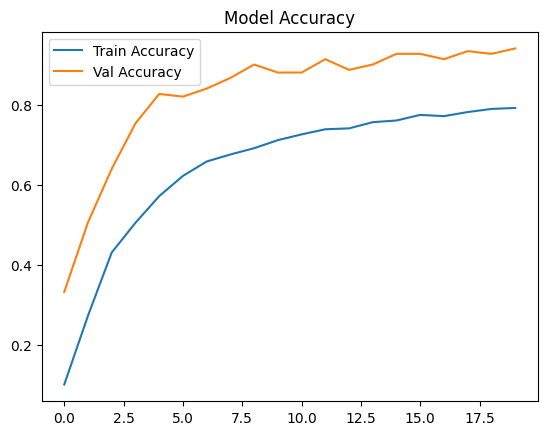

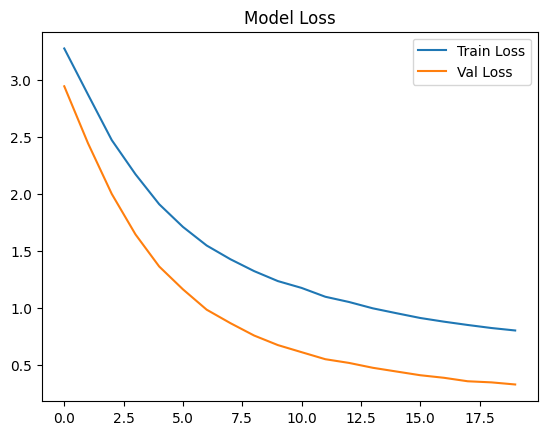

In [76]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

### Test the Model

In [77]:
import cv2
from matplotlib import pyplot as plt

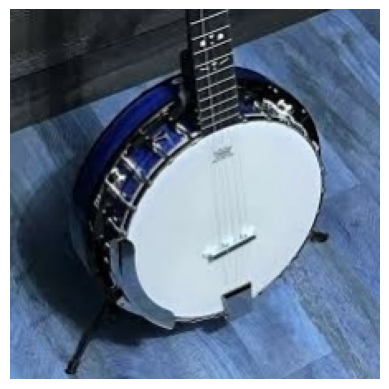

In [95]:
image = '/kaggle/input/musical-instruments-image-classification/6 test samples/4.jpg'
image = cv2.imread(image)
plt.imshow(image)
plt.axis(False)
plt.show()

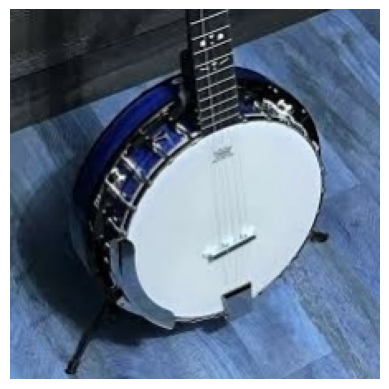

In [96]:
resize = tf.image.resize(image, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.axis(False)
plt.show()

### Make Prediction

In [97]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [98]:
yhat

array([[9.6577998e-05, 4.4239994e-02, 2.4433987e-04, 2.0936236e-03,
        8.7441923e-04, 4.5674221e-04, 8.4766454e-01, 4.0532132e-03,
        1.4728177e-03, 4.4710224e-04, 2.0832031e-03, 9.4881958e-05,
        1.3357457e-03, 5.1821250e-02, 1.6016999e-03, 7.5365271e-04,
        8.1664644e-04, 3.8945198e-03, 6.8081754e-05, 4.2788150e-05,
        3.0207765e-04, 3.1476779e-04, 7.1811792e-04, 1.1310296e-04,
        6.2577743e-03, 2.5542423e-02, 3.1554999e-04, 2.6174349e-04,
        6.9708127e-04, 1.3215587e-03]], dtype=float32)

In [99]:
score = tf.nn.softmax(yhat)

In [100]:
print('Intrument in image is {} with accuracy of {:0.2f}'.format(classes_list[np.argmax(score)],np.max(score)*100))

Intrument in image is banjo with accuracy of 7.41


In [101]:
model.save('/kaggle/working/instrument_classification.h5')